# Data
The Data comes from:
https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection

# Context
<p>
    
Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.

To overcome the limitations related to noise in Twitter datasets, this News Headlines dataset for Sarcasm Detection is collected from two news website. TheOnion aims at producing sarcastic versions of current events and we collected all the headlines from News in Brief and News in Photos categories (which are sarcastic). We collect real (and non-sarcastic) news headlines from HuffPost.

This new dataset has following advantages over the existing Twitter datasets:

Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.

Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.

Unlike tweets which are replies to other tweets, the news headlines we obtained are self-contained. This would help us in teasing apart the real sarcastic elements.
</p>

# Content

<p>
Each record consists of three attributes:

is_sarcastic: 1 if the record is sarcastic otherwise 0

headline: the headline of the news article

article_link: link to the original news article. Useful in collecting supplementary data
    </p>

# Contents

[1. Imports](#1)
<br></br>
[2. EDA](#2)
<br></br>
[3. Data PreProcessing](#3)
<br></br>
[4. Creating and Trening a Model](#4)
<br></br>
[5. Model Evaluation](#5)

<span id = "2"></span>
# Imports

In [185]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import string

from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sns.set_style('whitegrid')

In [32]:
uploaded = files.upload()

Saving Sarcasm_Headlines_Dataset.json to Sarcasm_Headlines_Dataset.json


In [3]:
uploaded2 = files.upload()

Saving Sarcasm_Headlines_Dataset_v2.json to Sarcasm_Headlines_Dataset_v2.json


In [242]:
data1 = pd.read_json(open("Sarcasm_Headlines_Dataset_v2.json", "r"),lines=True)
data2 = pd.read_json(open("Sarcasm_Headlines_Dataset.json", "r"),lines=True)
df = pd.concat([data1, data2], ignore_index=True)
df.head(10)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...
6,0,5 ways to file your taxes with less stress,https://www.huffingtonpost.com/entry/5-ways-to...
7,1,richard branson's global-warming donation near...,https://www.theonion.com/richard-bransons-glob...
8,1,shadow government getting too large to meet in...,https://politics.theonion.com/shadow-governmen...
9,0,lots of parents know this scenario,https://www.huffingtonpost.comhttp://pubx.co/6...


In [243]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55328 entries, 0 to 55327
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  55328 non-null  int64 
 1   headline      55328 non-null  object
 2   article_link  55328 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


<span id = "3"></span>
# EDA

Text(0.5, 1.0, 'Countplot of headlines')

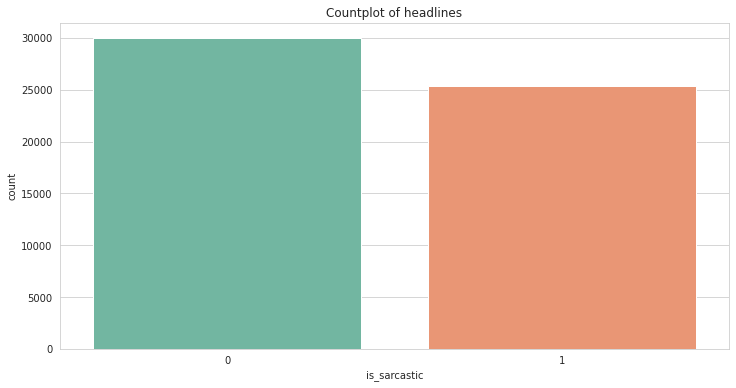

In [244]:
# Check number of headlines by is_sarcastics
plt.figure(figsize=(12,6))
sns.countplot(x = 'is_sarcastic', data = df, palette="Set2").set_title("Countplot of headlines")

In [245]:
# Add new column 'headline_len': Text length of headline 
df['headline_len'] = df['headline'].map(len)

In [246]:
# Define function which takes full article link and extract string with website name
def extract_website(link):
  return link.split('//')[1].split('.com')[0].replace('www.', "")

In [247]:
# Apply extract_website func to df article_link and create new column with website name
df['website'] = df['article_link'].apply((lambda x: extract_website(x)))

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

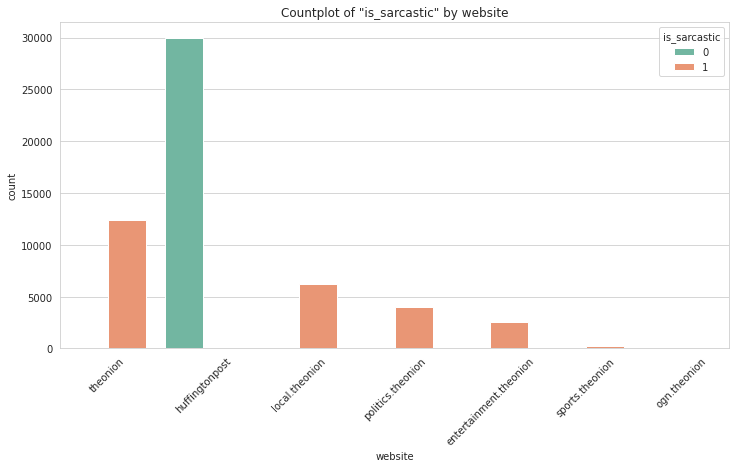

In [248]:
# Check number of headlines by is_sarcastic for every website
plt.figure(figsize=(12,6))
sns.countplot(data=df, x = 'website', hue='is_sarcastic', palette="Set2").set_title('Countplot of "is_sarcastic" by website')
plt.xticks(rotation=45)

In [249]:
# Sort dataframe by headline length. Check the longest headline.
df.sort_values(by='headline_len', ascending=False).head(4)

,is_sarcastic,headline,article_link,headline_len,website
7302,1,hot wheels ranked number one toy for rolling d...,https://www.theonion.com/hot-wheels-ranked-num...,926,theonion
2146,1,"maya angelou, poet, author, civil rights activ...",https://www.theonion.com/maya-angelou-poet-aut...,254,theonion
48487,1,"maya angelou, poet, author, civil rights activ...",https://www.theonion.com/maya-angelou-poet-aut...,254,theonion
16588,1,"'12 years a slave,' 'captain phillips,' 'ameri...",https://entertainment.theonion.com/12-years-a-...,238,entertainment.theonion


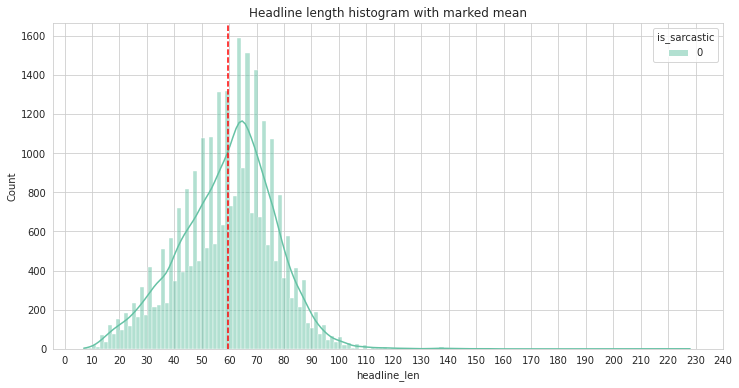

In [250]:
# Histogram of headline length for not "is_sarcastic"
plt.figure(figsize=(12,6))

# Headline len limited to 250
g = sns.histplot(data = df[(df['headline_len'] < 250) & (df['is_sarcastic'] == 0)], 
             x = 'headline_len', hue = 'is_sarcastic', kde = True, palette='Set2').set_title("Headline length histogram with marked mean")
# Set xticks
g = plt.xticks(np.arange(0, 250, 10))
# Show headline length mean for is_sarcastic = 0
g = plt.axvline(df[(df['headline_len'] < 250) & (df['is_sarcastic'] == 0)].headline_len.mean(), 
                color='r', linestyle = '--')

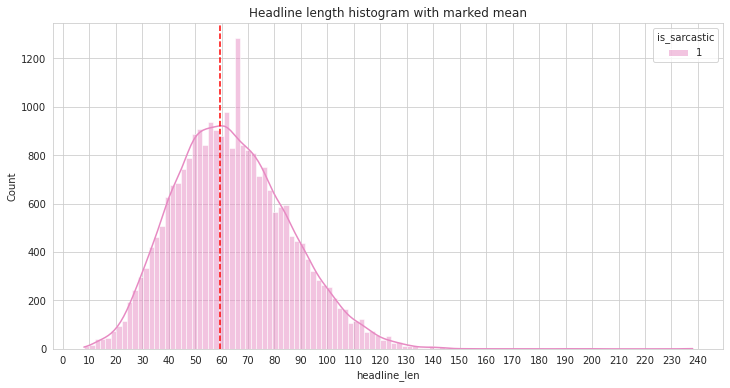

In [251]:
# Histogram of headline length for "is_sarcastic"
plt.figure(figsize=(12,6))

# Headline len limited to 250
g = sns.histplot(data = df[(df['headline_len'] < 250) & (df['is_sarcastic'] == 1)], 
             x = 'headline_len', hue = 'is_sarcastic', kde = True, palette='Set2_r').set_title("Headline length histogram with marked mean")
# Set xticks
g = plt.xticks(np.arange(0, 250, 10))
# Show headline length mean for is_sarcastic = 1
g = plt.axvline(df[(df['headline_len'] < 250) & (df['is_sarcastic'] == 0)].headline_len.mean(), 
                color='r', linestyle = '--')

<span id = "3"></span>
# Data PreProcessing

In [252]:
# List of stopwords
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [253]:
sentences = []
labels = []

# append all headlines text and label (is_sarcastic) to list
for ind, row in df.iterrows():
  labels.append(row['is_sarcastic'])

  sentence = row['headline']
  # remove stopwords in sentences
  for word in stopwords:
      token = " " + word + " "
      sentence = sentence.replace(token, " ")
      sentence = sentence.replace("  ", " ")
  sentences.append(sentence)

In [254]:
# def parse_data(file):
#     for l in open(file,'r'):
#         yield json.loads(l)

# data = list(parse_data('Sarcasm_Headlines_Dataset.json'))

# sentences = []
# labels = []

# for item in data:
#   sentences.append(item['headline'])
#   labels.append(item['is_sarcastic'])

In [255]:
def clean_sentences(sentences):
    '''
    Make text lowercase, remove text in square brackets, 
    remove punctuation and remove words containing numbers.
    '''
    cln_sentences = []
    for text in sentences:
      text = text.lower()
      text = re.sub('\[.*?\]', '', text)
      text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
      text = re.sub('\w*\d\w*', '', text)
      cln_sentences.append(text)
    return cln_sentences

sentences = clean_sentences(sentences)

In [256]:
# Set parameters
vocab_size = 10000    # Max len of unique words
embedding_dim = 200   # Embedding dimension value
max_length = 60       # Max length of sentence
padding_type = 'post' # pad_sequences arg
oov_tok = '<OOV>'     # Unknow words = <OOV>
training_portion = .7 # train test split 70:30

In [257]:
# Set the train size using training_portion arg
train_size = int(len(sentences) * training_portion)

# Split
train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

# Check
print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

38729
38729
38729
16599
16599


In [258]:
# Tokenizing and padding
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen = max_length)

In [259]:
# Prepare labels for model
training_labels_final = np.array(train_labels)
validation_labels_final = np.array(validation_labels)

# Check shapes
print(training_labels_final.shape)
print(validation_labels_final.shape)

(38729,)
(16599,)


<span id = "4"></span>
# Creating and Trening a Model

In [260]:
# MODEL
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(40, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [261]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 60, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 40)                8040      
_________________________________________________________________
dropout_12 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 20)                820       
_________________________________________________________________
dropout_13 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)               

In [262]:
# Fit the model
num_epochs = 6
history = model.fit(train_padded, training_labels_final, epochs=num_epochs, validation_data=(validation_padded, validation_labels_final))

Epoch 1/6
1211/1211 [==============================] - 30s 24ms/step - loss: 0.5854 - accuracy: 0.6885 - val_loss: 0.3715 - val_accuracy: 0.8660
Epoch 2/6
1211/1211 [==============================] - 29s 24ms/step - loss: 0.3603 - accuracy: 0.8688 - val_loss: 0.2359 - val_accuracy: 0.9242
Epoch 3/6
1211/1211 [==============================] - 28s 23ms/step - loss: 0.2332 - accuracy: 0.9255 - val_loss: 0.1576 - val_accuracy: 0.9494
Epoch 4/6
1211/1211 [==============================] - 28s 23ms/step - loss: 0.1684 - accuracy: 0.9528 - val_loss: 0.1187 - val_accuracy: 0.9649
Epoch 5/6
1211/1211 [==============================] - 29s 24ms/step - loss: 0.1272 - accuracy: 0.9664 - val_loss: 0.1042 - val_accuracy: 0.9704
Epoch 6/6
1211/1211 [==============================] - 33s 28ms/step - loss: 0.1067 - accuracy: 0.9728 - val_loss: 0.0916 - val_accuracy: 0.9752


<span id = "5"></span>
# Model Evaluation

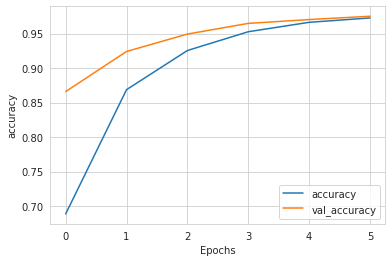

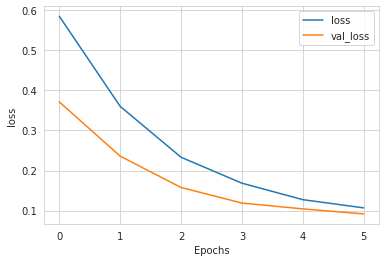

In [263]:
# Plot train and validation Accuracy and Loss
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
print("")
plot_graphs(history, "loss")

In [264]:
# Make prediction
pred = model.predict_classes(validation_padded)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [265]:
# Print Confusion matrix
print(classification_report(validation_labels, pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       1.00      0.96      0.98      9367
    Sarcastic       0.95      1.00      0.97      7232

     accuracy                           0.98     16599
    macro avg       0.97      0.98      0.97     16599
 weighted avg       0.98      0.98      0.98     16599

